# imports and subroutines

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as plt

In [3]:
def sg(c,u,N,D):
  """
  stochastic gradient
  Dc ~= (1/N) * sum( [(c(u+d[n]) - c(u-d[n])) * d[n] / |d[n]|] for n in range(N) )

  inputs:
    c : U -> R
    u in U - decision variable in vector space U
    N - int - number of samples
    D > 0 - size of displacement

  outputs:
    Dc in N x U - approximations of gradient
  """
  # create displacements
  d = np.random.randn(N,u.size)
  #d /= np.linalg.norm(d,axis=1)[:,np.newaxis]
  d *= D
  d.reshape(tuple([N]+list(u.shape)))
  # compute stochastic gradient
  Dc = np.zeros_like(d)
  for n in range(N):
    Dc[n] = (c(u+d[n]) - c(u-d[n])) * d[n] 
  Dc /= 2*D**2
  return Dc

def gd(c,u0,Dc,g,I):
  """
  gradient descent
  for i in I:
    u -= g(u)*Dc(u)

  inputs:
    c : U -> R
    u0 in U - decision variable in vector space U
    g(u,i) > 0 - step size
    I - int - number of iterations

  outputs:
    U in I x U
  """
  U = np.nan*np.zeros((I,u0.size))
  U.reshape(tuple([I]+list(u0.shape)))
  U[0] = u0
  for i in range(I-1):
    U[i+1] = U[i] - g(U[i],i) * Dc(U[i])
  return U

def PSD(n,sqrt=False):
  """
  compute random positive semidefinite matrix

  input:
    n - int - dimension of matrix
    (optional)
    sqrt - bool - whether to return S such that Q = np.dot( S.T, S)

  output:
    Q - n x n - Q = Q^T,  spec Q \subset [0,oo)
  """
  H = np.random.randn( n, n )
  d,u = np.linalg.eig( H + H.T )
  d *= np.sqrt(np.arange(d.size)+.1)
  S = np.dot( u, np.dot( np.diag( np.sqrt( d*np.sign( d ) ) ), u.T ) )
  Q = np.dot( S.T, S )
  if sqrt:
    return Q, S
  else:
    return Q

# 1D test

## define cost, check derivative

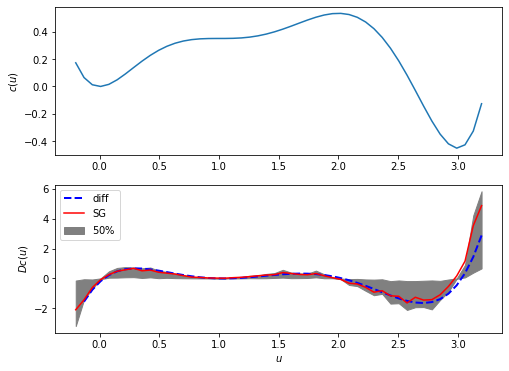

In [4]:
N = 100
D = 1e-1

if 0:
  xlim = (-1,+1)
  c = lambda u : u**2 #+ np.random.randn(*u.shape)/10
else:
  c = lambda u : u**6/6-7*u**5/5+17*u**4/4-17*u**3/3+3*u**2
  xlim = (-.2,3.2)

U = np.linspace(*xlim)[:,np.newaxis]
cU = c(U)
DcU = np.diff(cU.flatten()) / np.diff(U.flatten())
Dc = np.asarray([sg(c,u,N,D) for u in U])

plt.figure(figsize=(8,6))
ax = plt.subplot(2,1,1)
ax.plot(U,cU)
ax.set_ylabel(r'$c(u)$')
ax = plt.subplot(2,1,2)
ax.plot(U[1:],DcU,'b--',lw=2,label='diff')
ax.plot(U,Dc.mean(axis=1),'r',label='SG')
ax.fill_between(U.flatten(),
                np.percentile(Dc,75,axis=1).flatten(),
                np.percentile(Dc,25,axis=1).flatten(),
                color='gray',label=r'$50\%$')
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$Dc(u)$')
ax.legend()

## descend cost

In [5]:
Dc = lambda u : sg(c,u,N,D).mean(axis=0)
g = lambda u,i : 1e-1#/(i+1)
I = 20

U_ = []
cU_ = []
for _ in range(100):
  u0 = np.array([np.random.uniform(xlim[0],xlim[1])])
  U_.append(gd(c,u0,Dc,g,I))
  cU_.append(c(U_[-1]))
U_ = np.asarray(U_)
cU_ = np.asarray(cU_)

Text(0.5, 0, 'iteration')

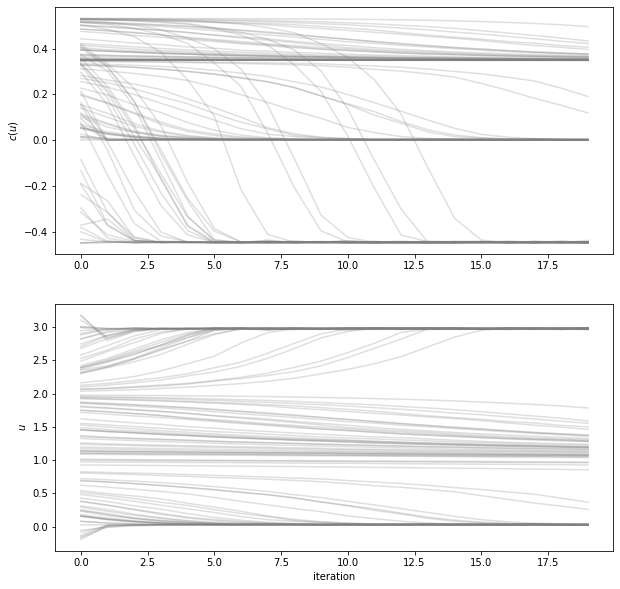

In [6]:
costs = cU_[...,0].T
inputs = U_[...,0].T

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
ax.plot(costs,color='gray',alpha=0.25);
#[q1,m,q2] = np.percentile(costs,[25,50,75],axis=1)
#ax.fill_between(np.arange(q1.size),q1,q2,color='r',alpha=0.5)
#ax.plot(m,color='r',linewidth=4)
ax.set_ylabel(r'$c(u)$')

ax = plt.subplot(2,1,2)
ax.plot(inputs,color='gray',alpha=0.25);
#[q1,m,q2] = np.percentile(inputs,[25,50,75],axis=1)
#ax.fill_between(np.arange(q1.size),q1,q2,color='r',alpha=0.5)
#ax.plot(m,color='r',linewidth=4)
ax.set_ylabel(r'$u$')
ax.set_xlabel(r'iteration')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


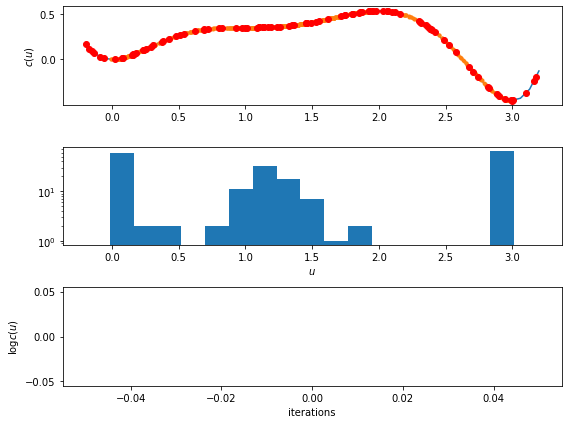

In [7]:
plt.figure(figsize=(8,6))
ax = plt.subplot(3,1,1)
ax.plot(U,cU)
ax.plot(U_.flatten(),c(U_.flatten()),'.')
ax.plot(U_[:,0].flatten(),c(U_[:,0].flatten()),'ro')
xlim = np.array(ax.get_xlim())
ax.set_ylabel(r'$c(u)$')
ax = plt.subplot(3,1,2)
ax.hist(U_[:,-I//10:,:].flatten(),bins=I//1+1,range=xlim/1,log=True)
ax.set_xlim(xlim)
ax.set_xlabel(r'$u$')
ax = plt.subplot(3,1,3)
ax.plot(np.percentile(np.log(cU_),50,axis=0))
ax.fill_between(np.arange(I),
                np.percentile(np.log(cU_),0,axis=0).flatten(),
                np.percentile(np.log(cU_),100,axis=0).flatten(),
                color='gray');
ax.set_xlabel(r'iterations')
ax.set_ylabel(r'$\log c(u)$')
plt.tight_layout()

# 2D test

## define cost

In [8]:
d = 2

lim = (-1,+1)

u1 = np.linspace(*lim)
u2 = np.linspace(*lim)

U1,U2 = np.meshgrid(u1,u2)

U = np.vstack((U1.flatten(),U2.flatten())).T

C = PSD(d)

# assumes u's are rows for convenience
c_diagdot = lambda u : np.diag(np.dot(u, np.dot(C, u.T)))
c_einsum = lambda u : np.einsum('ij,jk,ki->i',u,C,u.T)
if 0:
  assert np.allclose(c_diagdot(U),c_einsum(U)),"einsum correct ?"
  from timeit import timeit as ti
  print('einsum works (!) & is ~%0.1fx faster than diagdot'
        %(ti(lambda : c_diagdot(U),number=100)/ti(lambda : c_einsum(U),number=100)))
def c(u):
  if len(u.shape) == 1:
    u = u[np.newaxis]
  return c_einsum(u) #+ np.random.rand(len(u))/10
Dc = lambda u : 2*np.dot(U,C)

## visualize cost

Text(0, 0.5, '$u_2$')

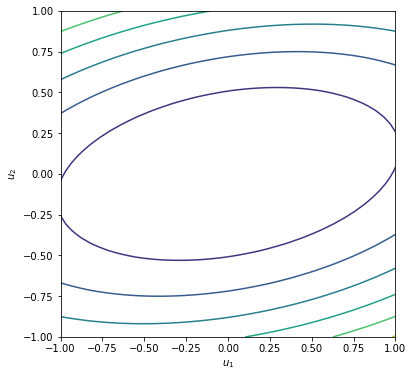

In [9]:
cU = c(U)

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
ax.contour(U1,U2,cU.reshape(u1.size,u2.size))
ax.set_xlabel(r'$u_1$')
ax.set_ylabel(r'$u_2$')

## descend cost

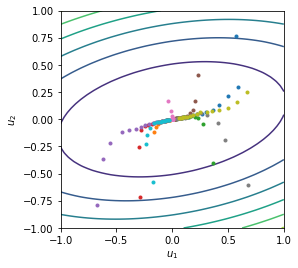

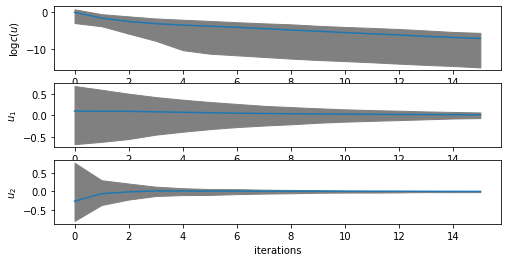

In [10]:
Dc = lambda u : sg(c,u,N,D).mean(axis=0)
g = lambda u,i : 1e-1#/(i+1)
I = 2**4

U_ = []
cU_ = []
for _ in range(10):
  u0 = np.array([[np.random.uniform(lim[0],lim[1]) for _ in range(d)]])
  U_.append(gd(c,u0,Dc,g,I))
  cU_.append(c(U_[-1]))

U_ = np.asarray(U_)
cU_ = np.asarray(cU_)

plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)
ax.contour(U1,U2,cU.reshape(u1.size,u2.size))
for _ in U_:
  ax.plot(_[:,0],_[:,1],'.')

ax.set_xlabel(r'$u_1$')
ax.set_ylabel(r'$u_2$')

plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
ax.plot(np.percentile(np.log(cU_),50,axis=0))
ax.fill_between(np.arange(I),
                np.percentile(np.log(cU_),0,axis=0).flatten(),
                np.percentile(np.log(cU_),100,axis=0).flatten(),
                color='gray');
ax.set_ylabel(r'$\log c(u)$')
ax = plt.subplot(3,1,2)
ax.plot(np.percentile(U_[:,:,0],50,axis=0))
ax.fill_between(np.arange(I),
                np.percentile(U_[:,:,0],0,axis=0).flatten(),
                np.percentile(U_[:,:,0],100,axis=0).flatten(),
                color='gray');
ax.set_ylabel(r'$u_1$')
ax = plt.subplot(3,1,3)
ax.plot(np.percentile(U_[:,:,1],50,axis=0))
ax.fill_between(np.arange(I),
                np.percentile(U_[:,:,1],0,axis=0).flatten(),
                np.percentile(U_[:,:,1],100,axis=0).flatten(),
                color='gray');
ax.set_ylabel(r'$u_2$')
ax.set_xlabel(r'iterations')

pass

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF
